In [1]:
# !dwave auth login # To login into the dwave leap account

In [2]:
# !dwave config create # To configure your account with solver

In [3]:
# !dwave ping --client qpu # To call your qpu availibilty from Dwave-leap account

In [1]:
from docplex.mp.model import Model
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt
from qiskit_optimization.converters import QuadraticProgramToQubo
# from qiskit import BasicAer
# from qiskit.algorithms import QAOA, NumPyMinimumEigensolver
from qiskit_optimization.algorithms import CplexOptimizer, MinimumEigenOptimizer
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp
from qiskit_optimization.applications import BinPacking, Tsp
from brute_force_bpp import *
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from vqa_pennylane import *

ModuleNotFoundError: No module named 'brute_force_bpp'

In [4]:
def data_bins(result, weights, n, m, C, simplify=False):
    """
    Organizes the results of the ILP Bin Packing optimization into bins.

    Parameters:
    result (OptimizationResult): Optimization result from the solver.
    weights (list): Weights of each item.
    n (int): Number of items.
    m (int): Maximum possible number of bins.
    C (int): Capacity of each bin.
    simplify (bool): Flag to simplify the output (optional).

    Returns:
    dict: Dictionary with keys "bins", "items", and "index" for bin data.
    """
    # Extract variables dictionary from the result
    variables_dict = result.variables_dict

    # Initialize arrays for decision variables
    x_vars = np.zeros((m, n))
    y_vars = np.zeros(m)

    # Retrieve values from the variables dictionary
    for j in range(m):
        y_vars[j] = variables_dict.get(f"y_{j}", 0)  # Bin j status
        for i in range(n):
            x_vars[j, i] = variables_dict.get(f"x_{i}_{j}", 0)  # Item i in bin j

    # Calculate the weight of items in each bin
    items = x_vars * weights
    bins = y_vars

    return {"bins": bins, "items": items, "index": np.arange(m)}



In [5]:

def plot_bins(result, weights, n, m, C, simplify=False):
    """
    Plots the results of the ILP Bin Packing solution in a bar diagram.

    Parameters:
    result (OptimizationResult): Optimization result from the solver.
    weights (list): Weights of each item.
    n (int): Number of items.
    m (int): Maximum possible number of bins.
    C (int): Capacity of each bin.
    simplify (bool): Flag to simplify the plot (optional).
    """
    res = data_bins(result, weights, n, m, C, simplify)
    plt.figure(figsize=(10, 6))

    # Bin index and initial bar for first item
    ind = res["index"]
    
    # Add first item with label
    suma = res["items"][:, 0]  # Initialize bottom for stacking bars
    plt.bar(ind, suma, label=f"Item 0 ({weights[0]:.2f})")  # label for item 0

    # Stack items in each bin, starting from item 1
    for j in range(1, n):
        plt.bar(ind, res["items"][:, j], bottom=suma, label=f"Item {j} ({weights[j]:.2f})")
        suma += res["items"][:, j]

    # Add a line for the bin capacity
    plt.hlines(C, -0.5, m - 0.5, linestyle="--", color="r", label="Max Capacity (C)")

    plt.xticks(ind)
    plt.xlabel("Bin")
    plt.ylabel("Weight")
    plt.legend()
    plt.title("Bin Packing Solution(MinimumEigenOptimizer)")
    plt.show()


## Formulation

The **Bin Packing Problem (BPP)** is a classic optimization problem where we are given a set of items with specific weights and bins with a fixed capacity. The goal is to pack all items into the minimum number of bins without exceeding the capacity of any bin.

### Problem Definition

- Given $n$ items with weights $w_1, w_2, \ldots, w_n$ and bin capacity $C$.
- Minimize the number of bins used.

### ILP Formulation

**Decision Variables:**
- $x_{ij}$: 1 if item $i$ is in bin $j$, 0 otherwise.
- $y_j$: 1 if bin $j$ is used, 0 otherwise.

**Objective Function:**
$$
\text{Minimize } \sum_{j=1}^{m} y_j
$$
where $m$ is an upper bound on the number of bins.

**Constraints:**
1. Each item must be assigned to exactly one bin:
   $$
   \sum_{j=1}^{m} x_{ij} = 1, \quad \forall i \in \{1, 2, \ldots, n\}
   $$
2. The total weight in each bin cannot exceed its capacity:
   $$
   \sum_{i=1}^{n} w_i x_{ij} \leq C y_j, \quad \forall j \in \{1, 2, \ldots, m\}
   $$
3. Binary constraints:
   $$
   x_{ij} \in \{0, 1\}, \quad y_j \in \{0, 1\}
   $$

### Explanation of Terms
- **Objective Function**: Represents the total number of bins used.
- **Constraint 1**: Ensures each item is placed in exactly one bin.
- **Constraint 2**: Ensures the weight in each bin does not exceed $C$.
- **Binary Constraints**: Ensure $x_{ij}$ and $y_j$ are binary variables.


In [6]:

def bpp_to_ilp(weights, C):
    # Initialize model
    model = Model(name="Bin Packing Problem")
    n = len(weights)
    m = min_bins(weights, C)
    # Decision Variables
    # x[i, j] = 1 if item i is placed in bin j, 0 otherwise
    x = {(i, j): model.binary_var(name=f"x_{i}_{j}") for i in range(n) for j in range(m)}

    # y[j] = 1 if bin j is used, 0 otherwise
    y = {j: model.binary_var(name=f"y_{j}") for j in range(m)}
    # Constraints

    # 1. Each item must be assigned to exactly one bin
    for i in range(n):
        model.add_constraint(model.sum(x[i, j] for j in range(m)) == 1, ctname=f"assign_item_{i}")

    # 2. Total weight in each bin cannot exceed bin capacity
    for j in range(m):
        model.add_constraint(model.sum(weights[i] * x[i, j] for i in range(n)) <= C * y[j], ctname=f"capacity_bin_{j}")
    # 3. Enforce that the first item is assigned to the first bin
    model.add_constraint(x[0, 0] == 1, ctname="first_item_first_bin")

    # Objective: Minimize the number of bins used
    model.minimize(model.sum(y[j] for j in range(m)))
    
    return model


In [10]:
# weights = [2,3,1,3]
# C = 5
weights = [3, 2, 3, 4]  # Weights of 4 items
C =  max(weights) +2 # Bin capacity

mod = bpp_to_ilp(weights, C)
mod.export_as_lp_string()
# mod.number_of_binary_variables

'\\ This file has been generated by DOcplex\n\\ ENCODING=ISO-8859-1\n\\Problem name: Bin Packing Problem\n\nMinimize\n obj: y_0 + y_1\nSubject To\n assign_item_0: x_0_0 + x_0_1 = 1\n assign_item_1: x_1_0 + x_1_1 = 1\n assign_item_2: x_2_0 + x_2_1 = 1\n assign_item_3: x_3_0 + x_3_1 = 1\n capacity_bin_0: 3 x_0_0 + 2 x_1_0 + 3 x_2_0 + 4 x_3_0 - 6 y_0 <= 0\n capacity_bin_1: 3 x_0_1 + 2 x_1_1 + 3 x_2_1 + 4 x_3_1 - 6 y_1 <= 0\n first_item_first_bin: x_0_0 = 1\n\nBounds\n 0 <= x_0_0 <= 1\n 0 <= x_0_1 <= 1\n 0 <= x_1_0 <= 1\n 0 <= x_1_1 <= 1\n 0 <= x_2_0 <= 1\n 0 <= x_2_1 <= 1\n 0 <= x_3_0 <= 1\n 0 <= x_3_1 <= 1\n 0 <= y_0 <= 1\n 0 <= y_1 <= 1\n\nBinaries\n x_0_0 x_0_1 x_1_0 x_1_1 x_2_0 x_2_1 x_3_0 x_3_1 y_0 y_1\nEnd\n'

In [25]:
# mod = from_docplex_mp(model)
# # Solving Quadratic Program using CPLEX
# cplex = CplexOptimizer()
# result = cplex.solve(mod)
# print(result)
# plot_bins(result, weights, n, m, C)
# result.variables_dict

from qiskit_optimization.applications import BinPacking

# Function to get the number of qubits for increasing item count
def get_qubits_BPPQ(max_items):
    num_variables = {}  # Dictionary to store the number of qubits for each item count
    
    for num_items in range(1, max_items + 1):
        # Generate weights list (for simplicity, weights are [1, 2, ..., num_items])
        weights = list(range(1, num_items + 1))  
        C = num_items + 1  # Setting bin capacity slightly larger than number of items
        
        # Initialize BinPacking problem
        bpp = BinPacking(weights, C, num_items)
        
        # Convert to quadratic program
        qp = bpp.to_quadratic_program()
        
        # Convert quadratic program to QUBO
        qp2qubo = QuadraticProgramToQubo()
        qubo = qp2qubo.convert(qp)

        # Convert QUBO to Ising representation to extract number of qubits
        qub, offset = qubo.to_ising()
        
        # Get the number of qubits (binary variables)
        num_qubits = qub.num_qubits
        
        # Store the result in the dictionary
        num_variables[num_items] = num_qubits#qubo.get_num_binary_vars()
    return num_variables

# Example usage
max_items = 15  # Define the maximum number of items for which we want to compute variables
num_variables = get_qubits_BPPQ(max_items)

# Output the dictionary with the number of qubits for each number of items
print("Number of qubits for increasing items:", num_variables)


# Output the results
print("no. of qubit", num_variables)


Number of qubits for increasing items: {1: 4, 2: 10, 3: 21, 4: 32, 5: 45, 6: 60, 7: 84, 8: 104, 9: 126, 10: 150, 11: 176, 12: 204, 13: 234, 14: 266, 15: 315}
no. of qubit {1: 4, 2: 10, 3: 21, 4: 32, 5: 45, 6: 60, 7: 84, 8: 104, 9: 126, 10: 150, 11: 176, 12: 204, 13: 234, 14: 266, 15: 315}


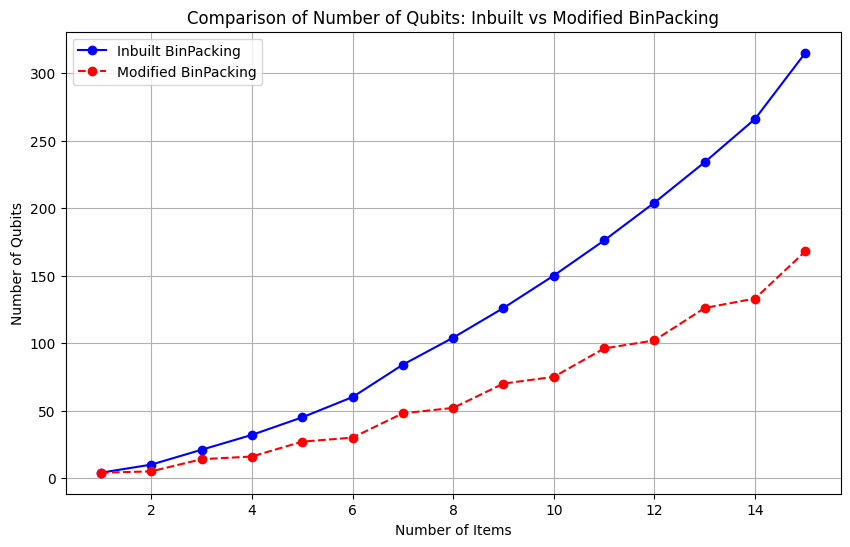

In [27]:
import matplotlib.pyplot as plt

# Data for the number of qubits in both versions
inbuilt_qubits = {1: 4, 2: 10, 3: 21, 4: 32, 5: 45, 6: 60, 7: 84, 8: 104, 9: 126, 10: 150, 11: 176, 12: 204, 13: 234, 14: 266, 15: 315}
modified_qubits = {1: 4, 2: 5, 3: 14, 4: 16, 5: 27, 6: 30, 7: 48, 8: 52, 9: 70, 10: 75, 11: 96, 12: 102, 13: 126, 14: 133, 15: 168}

# Extract keys (number of items) and values (number of qubits)
items = list(inbuilt_qubits.keys())
inbuilt_values = list(inbuilt_qubits.values())
modified_values = list(modified_qubits.values())

# Create a plot
plt.figure(figsize=(10, 6))
plt.plot(items, inbuilt_values, label="Inbuilt BinPacking", marker='o', linestyle='-', color='b')
plt.plot(items, modified_values, label="Modified BinPacking", marker='o', linestyle='--', color='r')

# Add labels and title
plt.xlabel('Number of Items')
plt.ylabel('Number of Qubits')
plt.title('Comparison of Number of Qubits: Inbuilt vs Modified BinPacking')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


In [26]:
# mod = from_docplex_mp(model)
# # Solving Quadratic Program using CPLEX
# cplex = CplexOptimizer()
# result = cplex.solve(mod)
# print(result)
# plot_bins(result, weights, n, m, C)
# result.variables_dict

from qiskit_optimization.applications import BinPacking

# Function to get the number of qubits for increasing item count
def get_qubits_BPP(max_items):
    num_variables = {}  # Dictionary to store the number of qubits for each item count
    
    for num_items in range(1, max_items + 1):
        # Generate weights list (for simplicity, weights are [1, 2, ..., num_items])
        weights = list(range(1, num_items + 1))  
        C = num_items + 1  # Setting bin capacity slightly larger than number of items
        
        # Initialize BinPacking problem
        bpp = bpp_to_ilp(weights, C)
        
        qubo = ilp_to_qubo(bpp)

        # Convert QUBO to Ising representation to extract number of qubits
        qub, offset = qubo.to_ising()
        
        # Get the number of qubits (binary variables)
        num_qubits = qub.num_qubits
        # num_qubits = qubo.get_num_binary_vars()
        
        # Store the result in the dictionary
        num_variables[num_items] = num_qubits
    
    return num_variables

# Example usage
max_items = 15  # Define the maximum number of items for which we want to compute variables
num_variables_modified = get_qubits_BPP(max_items)

# Output the dictionary with the number of qubits for each number of items
print("Number of qubits for increasing items:", num_variables_modified)


# Output the results
# print("no. of qubit", num_variables)


Number of qubits for increasing items: {1: 4, 2: 5, 3: 14, 4: 16, 5: 27, 6: 30, 7: 48, 8: 52, 9: 70, 10: 75, 11: 96, 12: 102, 13: 126, 14: 133, 15: 168}


### Objective Function

Minimize:

$$
\sum_{i=1}^{m} y_i + \alpha \left[ - \sum_{i=1}^{m} \left( C y_i - \sum_{j=1}^{n} w_j x_{ij} \right) + \left( \sum_{i=1}^{m} \left( C y_i - \sum_{j=1}^{n} w_j x_{ij} \right) \right)^2 \right]
$$

Where:
- $y_i$ is a binary variable indicating whether bin $i$ is used (1) or not (0).
- $x_{ij}$ is a binary variable indicating whether item $j$ is assigned to bin $i$.

### Subject to:

#### 1. Assignment Constraint:
Each item must be assigned to exactly one bin:

$$
\sum_{i=1}^{m} x_{ij} = 1 \quad \forall j = 1, \dots, n
$$

#### 2. Capacity Constraint:
The total weight in each bin cannot exceed its capacity if the bin is used:

$$
\sum_{j=1}^{n} w_j x_{ij} \leq C y_i \quad \forall i = 1, \dots, m
$$

#### 3. Binary Constraints:

For the assignment variables:

$$
x_{ij} \in \{0, 1\} \quad \forall i = 1, \dots, m \quad \text{and} \quad j = 1, \dots, n
$$

For the bin usage variables:

$$
y_i \in \{0, 1\} \quad \forall i = 1, \dots, m
$$


In [18]:
def ilp_to_qubo(docplex_model):
    """
    Converts a given ILP Docplex model to a QUBO model.

    Parameters:
    docplex_model: Model
        A Docplex model representing an ILP problem.

    Returns:
    qubo: Quadratic """

    qp = from_docplex_mp(docplex_model)
    qp2qubo = QuadraticProgramToQubo()
    qubo = qp2qubo.convert(qp)
    # print(qubo.prettyprint())
    return qubo

In [12]:
qresult = ilp_to_qubo(mod)

qresult.get_num_binary_vars()

16

In [13]:
# from dwave.system import DWaveSampler, EmbeddingComposite
# from qiskit_optimization.algorithms import MinimumEigenOptimizer
# from qiskit_optimization.converters import QuadraticProgramToQubo
# from qiskit_optimization.translators import from_docplex_mp

# def solve_qubo_on_dwave(qubo):
#     """
#     Solves the QUBO on D-Wave's quantum annealer.

#     Parameters:
#     qubo: QuadraticProgram
#         The QUBO problem generated by ilp_to_qubo.

#     Returns:
#     result: dict
#         The solution from D-Wave's quantum annealer.
#     """
#     # Convert the QUBO to a format compatible with D-Wave
#     qubo_dict = qubo.to_ising()[0]

#     # Define the sampler with an embedding to handle larger problems
#     sampler = EmbeddingComposite(DWaveSampler())

#     # Run the sampler on the QUBO model
#     sampleset = sampler.sample_qubo(qubo_dict, num_reads=100)

#     # Extract the best solution
#     best_solution = sampleset.first.sample
#     best_energy = sampleset.first.energy

#     print("Best Solution:", best_solution)
#     print("Energy:", best_energy)

#     return best_solution, best_energy

# # Example usage:
# # docplex_model = # Define your ILP model using docplex here
# # qubo_model = ilp_to_qubo(docplex_model)
# # best_solution, best_energy = solve_qubo_on_dwave(qubo_model)

# solve_qubo_on_dwave(qresult)

In [14]:
# result1 = cplex.solve(qresult)
# print(result1)


### Brute Force Algorithm for Bin Packing Problem

#### Algorithm Overview

1. **Inputs**:
   - `weights`: List of item weights that need to be packed.
   - `C`: Bin capacity, which we set as $C = \max(\text{weights}) + 2$ to ensure room for our items.

2. **Filter Valid Combinations**:
   - Create all possible combinations of binary variables $x_{ij}$, where $x_{ij} = 1$ means item $i$ goes into bin $j$, and $x_{ij} = 0$ means it doesn’t.
   - Filter these combinations to satisfy:
     $$
     \sum_{j} x_{ij} = 1 \quad \text{for each item} \ i
     $$
   - This ensures each item is placed in one bin only.

3. **Initialize with Minimum Bins**:
   - Start with $Y = 1$, so $y_1 = 1$ (bin 1 is in use) and all others set to $0$.

4. **Check Capacity**:
   - With $Y = 1$, look for any combinations of $x_{ij}$ that satisfy:
     $$
     \sum_{i} x_{ij} \times \texttt{weight}_i \leq C \quad \text{for all bins in use}
     $$
   - If you can't find a valid setup, increase $Y$ by 1 (using an additional bin) and repeat.
   - Keep increasing $Y$ until you find a feasible configuration.

5. **Output**:
   - Once a valid configuration is found, the resulting matrix shows the minimum number of bins needed and the assignment of each item to a bin.

#### Example

Let's say we have the following:

- **Input**:
  - Item weights: `weights = [3, 2, 3, 4, 1]`
  - Bin capacity: $C = \max(\text{weights}) + 2 = 6$

- **Output Matrix**:

$$
\begin{bmatrix}
x_{11} & x_{12} & x_{13} \\
x_{21} & x_{22} & x_{23} \\
x_{31} & x_{32} & x_{33} \\
x_{41} & x_{42} & x_{43} \\
x_{51} & x_{52} & x_{53} \\
\end{bmatrix} = 
\begin{bmatrix}
0 & 0 & 1 \\
0 & 0 & 1 \\
0 & 1 & 0 \\
1 & 0 & 0 \\
0 & 0 & 1 \\
\end{bmatrix}
$$

- **Explanation**:
   - Item 1 goes in Bin 3 ($x_{13} = 1$)
   - Item 2 goes in Bin 3 ($x_{23} = 1$)
   - Item 3 goes in Bin 2 ($x_{32} = 1$)
   - Item 4 goes in Bin 1 ($x_{41} = 1$)
   - Item 5 goes in Bin 3 ($x_{53} = 1$)

So, the minimum number of bins required is $Y = 3$, based on this setup!


In [ ]:
from brute_force_bpp import *

weights = [3, 2, 3, 4]  # Weights of 4 items
C =  max(weights) +2 # Bin capacity
brute_force(weights, C)


(array([[0, 1],
        [1, 0],
        [0, 1],
        [1, 0]]),
 2)

In [ ]:


# my model 
mod1 = bpp_to_ilp(weights, C)

mod1 = ilp_to_qubo(mod1)


# qubo = qp2qubo.convert(mod1)
qubitOp, offset = mod1.to_ising()

print(qubitOp.num_qubits)
exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
result = exact.solve(mod1)
print(result.prettyprint())




16
objective function value: 2.0
variable values: x_0_0=1.0, x_0_1=0.0, x_1_0=0.0, x_1_1=1.0, x_2_0=1.0, x_2_1=0.0, x_3_0=0.0, x_3_1=1.0, y_0=1.0, y_1=1.0, capacity_bin_0@int_slack@0=0.0, capacity_bin_0@int_slack@1=0.0, capacity_bin_0@int_slack@2=0.0, capacity_bin_1@int_slack@0=0.0, capacity_bin_1@int_slack@1=0.0, capacity_bin_1@int_slack@2=0.0
status: SUCCESS


In [35]:
mod1 = bpp_to_ilp(weights, C)

mod1_qubo = ilp_to_qubo(mod1)

qubitOp, offset = mod1_qubo.to_ising()

print(qubitOp.num_qubits)
# exact = MinimumEigenOptimizer(NumPyMinimumEigensolver())
# result = exact.solve(mod1)
# print(result.prettyprint())
mod1_qubo.binary_var()

16


<Variable: x16 (binary)>

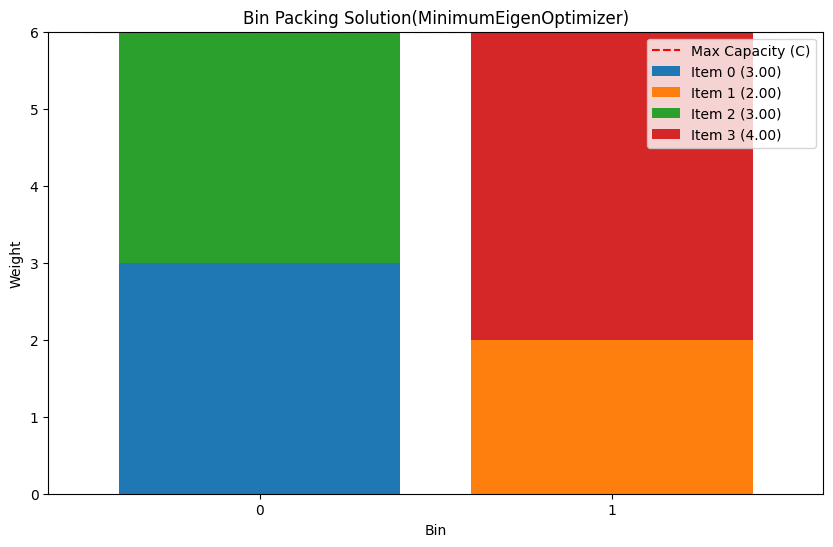

In [17]:
plot_bins(result, weights, len(weights), min_bins(weights, C), C)


### VQA Approach

In [18]:
# solving Quadratic Program using exact classical eigensolver

ee = NumPyMinimumEigensolver()
result = ee.compute_minimum_eigenvalue(qubitOp)


data = result.eigenstate
rounded_statevector = np.round(data.data, decimals=1)
# def VQA_qubo(qubo_model):

#     qubo_model.to_ising()

print(rounded_statevector)

[0.+0.j 0.+0.j 0.+0.j ... 0.+0.j 0.+0.j 0.+0.j]


In [19]:

# def alternating_layer_ansatz(params, wires):
#     num_wires = len(wires)
#     for i in range(num_wires):
#         qml.RX(params[i], wires=wires[i])
#         qml.RY(params[num_wires + i], wires=wires[i])
#     for i in range(num_wires - 1):
#         qml.CNOT(wires=[wires[i], wires[i + 1]])


# find_eigenstate(mod1,alternating_layer_ansatz)

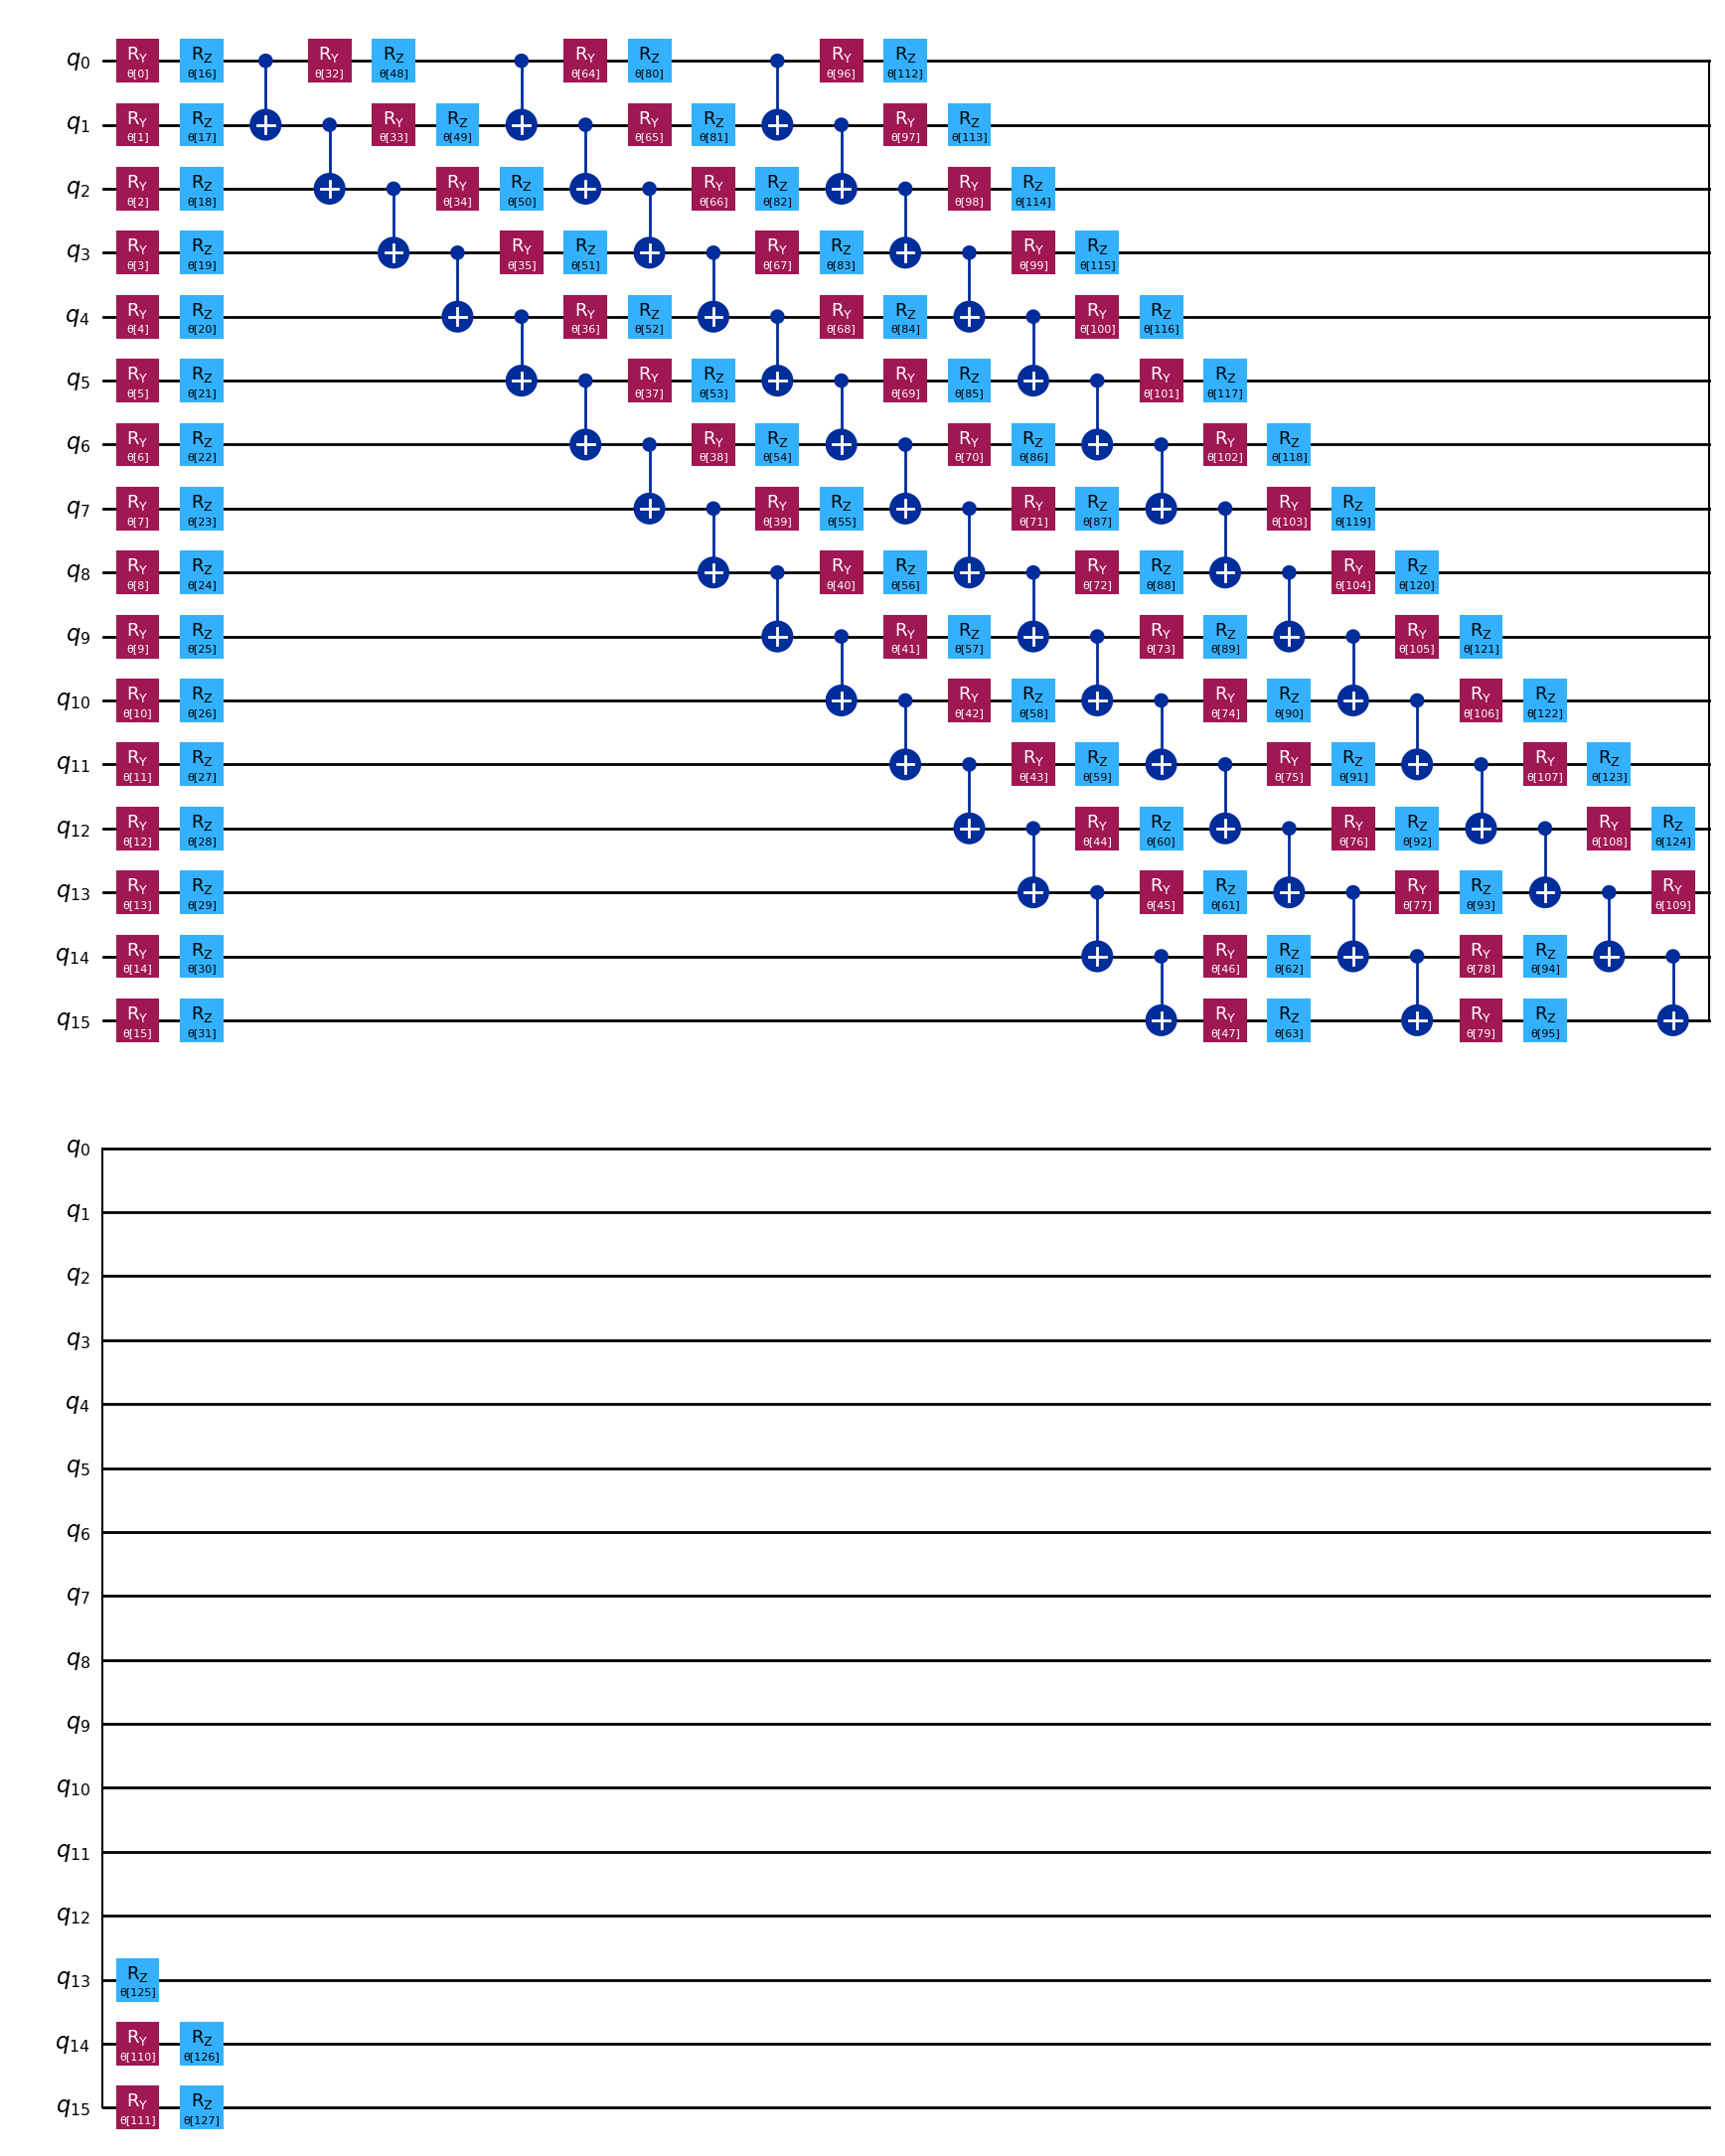

In [20]:
from qiskit.circuit.library import EfficientSU2
from qiskit_algorithms.optimizers import COBYLA

optimizer = COBYLA(maxiter=100)

num_qubits = qubitOp.num_qubits
ansatz = EfficientSU2(num_qubits, entanglement='linear')

ansatz = ansatz.decompose()
ansatz.draw(output="mpl")


In [21]:
# from qiskit_algorithms import VQE

# vqe = VQE(ansatz, optimizer, quantum_instance=quantum_instance)
# result = vqe.compute_minimum_eigenvalue(qubitOp)

# VQE

In [22]:
# useful additional packages
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from qiskit.circuit.library import TwoLocal
from qiskit_optimization.applications import Maxcut, Tsp
from qiskit_algorithms import SamplingVQE, NumPyMinimumEigensolver
from qiskit_algorithms.optimizers import SPSA
from qiskit_algorithms.utils import algorithm_globals
from qiskit.primitives import Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [23]:
algorithm_globals.random_seed = 123
seed = 10598

In [24]:
# construct SamplingVQE
optimizer = SPSA(maxiter=300)
ry = TwoLocal(qubitOp.num_qubits, "ry", "cz", reps=5, entanglement="linear")
vqe = SamplingVQE(sampler=Sampler(), ansatz=ry, optimizer=optimizer)

# run SamplingVQE
resultvqe = vqe.compute_minimum_eigenvalue(qubitOp)

# print results
print("energy:", resultvqe.eigenvalue.real)
print("time:", resultvqe.optimizer_time)
print("max-cut objective:", resultvqe.eigenvalue.real + offset)

energy: -328.70164949783003
time: 2899.6781902313232
max-cut objective: 27.798350502169967


In [26]:
from qiskit.primitives import Sampler
from qiskit.quantum_info import Pauli
from qiskit.result import QuasiDistribution

from qiskit_algorithms import QAOA
from qiskit_algorithms.optimizers import COBYLA

from qiskit_algorithms.utils import algorithm_globals

sampler = Sampler()
def bitfield(n, L):
    result = np.binary_repr(n, L)
    return [int(digit) for digit in result]  # [2:] to chop off the "0b" part


def sample_most_likely(state_vector):
    """Compute the most likely binary string from state vector.
    Args:
        state_vector: State vector or quasi-distribution.

    Returns:
        Binary string as an array of ints.
    """
    if isinstance(state_vector, QuasiDistribution):
        values = list(state_vector.values())
    else:
        values = state_vector
    n = int(np.log2(len(values)))
    k = np.argmax(np.abs(values))
    x = bitfield(k, n)
    x.reverse()
    return np.asarray(x)

x = sample_most_likely(result.eigenstate)

print(x)

[1 0 0 1 1 0 0 1 1 1 0 0 0 0 0 0]


In [27]:
# create minimum eigen optimizer based on SamplingVQE
vqe_optimizer = MinimumEigenOptimizer(vqe)

# solve quadratic program
resultvqeo = vqe_optimizer.solve(mod1)
# print(resultvqeo.prettyprint())

KeyboardInterrupt: 

In [ ]:
result

TypeError: SamplingVQE._build_sampling_vqe_result() missing 6 required positional arguments: 'ansatz', 'optimizer_result', 'aux_operators_evaluated', 'best_measurement', 'final_state', and 'optimizer_time'